# **Random Forest Classifier**

In [1]:
import pandas as pd
import sys
sys.path.append('..')
from utils import center_and_scale, correlations, plot_correlations

In [2]:
races_df = pd.read_csv('../dataset/races_classification.csv')

In [3]:
races_df.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'position', 'cyclist', 'cyclist_age', 'is_tarmac',
       'cyclist_team', 'start_date', 'duration', 'cyclist_number', 'top_20',
       'cyclist_level', 'cyclist_experience', 'relative_position',
       'avg_relative_position', 'cyclist_experience_profile',
       'avg_rel_position_profile', 'length_cat', 'cyclist_experience_length',
       'avg_rel_position_length', 'climb_cat', 'relative_position_sum',
       'cyclist_experience_climb', 'avg_rel_position_climb',
       'avg_cyclist_level', 'position_entropy', 'top_20_entropy'],
      dtype='object')

## Dataset Preparation

In [4]:
df = races_df.drop(columns=['_url', 'name','length', 'climb_total', 'profile', 
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration','cyclist_number', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'cyclist_experience', 'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'position_entropy', 'relative_position',])

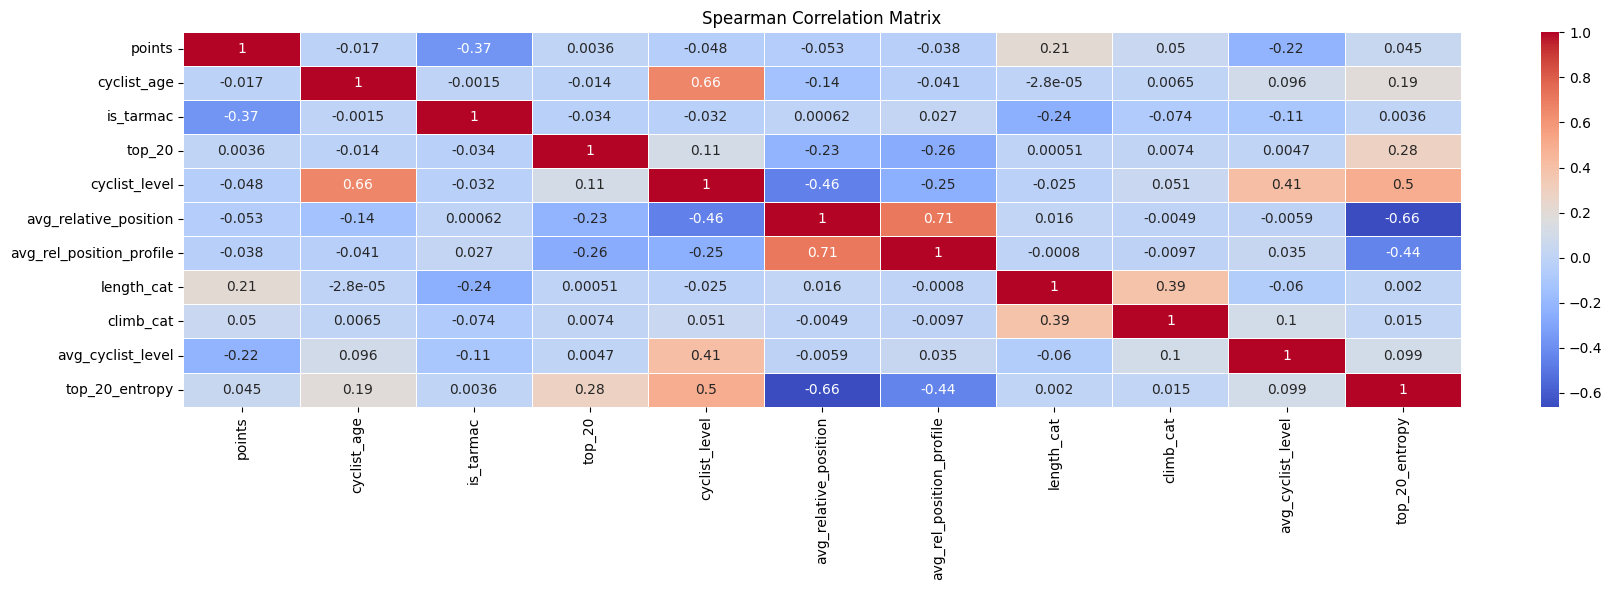

In [5]:
normalized_cyclist, normalization_scalers_cyclist = center_and_scale(df)
cyclists_corr = correlations(normalized_cyclist, ["spearman"])
plot_correlations(cyclists_corr)

Split the dataset according to task request

In [6]:
test_data = df[df['start_date'] >= '2020-01-01']
train_data = df[df['start_date'] < '2020-01-01']

train_data = train_data.drop(columns=['start_date'])
test_data = test_data.drop(columns=['start_date'])

train_labels = train_data['top_20']
test_labels = test_data['top_20']

Training data:

In [7]:
print("Training data percentage of overall data:", round(train_data.shape[0] / df.shape[0], 2))

Training data percentage of overall data: 0.84


In [8]:
train_data["top_20"].value_counts(normalize=True)

top_20
0    0.86791
1    0.13209
Name: proportion, dtype: float64

In [9]:
train_data.drop(columns=['top_20'], inplace=True)

Test data:

In [10]:
print("test data percentage of overall data:", round(test_data.shape[0] / df.shape[0], 2))

test data percentage of overall data: 0.16


In [11]:
test_data["top_20"].value_counts(normalize=True)

top_20
0    0.856025
1    0.143975
Name: proportion, dtype: float64

In [12]:
test_data.drop(columns=['top_20'], inplace=True)

note: dataset is already stratified on training and test data

## Decision Tree Model

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [14]:
# Defining sensitivity and specificity as metrics of sklearn
def specificity_score(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return tn / (tn + fp)

def sensitivity_score(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return tp / (tp + fn)

In [15]:
model = DecisionTreeClassifier(splitter='best', class_weight='balanced')

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 4, 6, 8 ,10],
    'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None]
}

scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

In [16]:
# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=50, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(class_weight='balanced'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 4, 6],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [10, 20, 30, 50,
                                                             100, 150, 200,
                                                             250],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   random_state=42, refit='f1',
                   scoring={'accuracy'...
                            'f1': make_scorer(f1_score, response_method='predict', average=binary),
                            'precision': make_scorer(precision_score, response_method='predict', average=binary),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(recall_score, response_method='predict', average=binary),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

Accuracy: 0.7099108117946851
Recall: 0.7154445849136115
Precision: 0.29252638380357526
Sensitivity: 0.7154445849136115
Specificity: 0.7089800836345596
F1 Score: 0.4152627877824319
ROC AUC Score: 0.7122123342740855


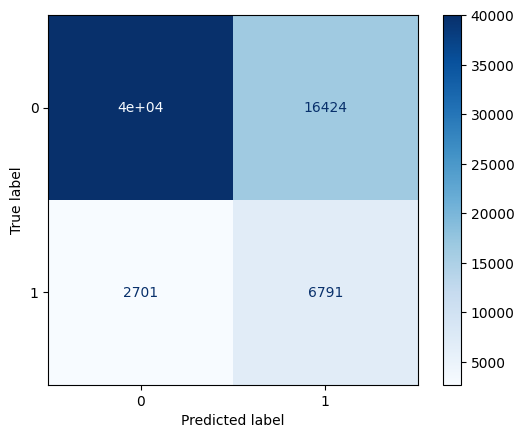

In [17]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
sensitivity_score = sensitivity_score(test_labels, test_predictions)
specificity_score = specificity_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


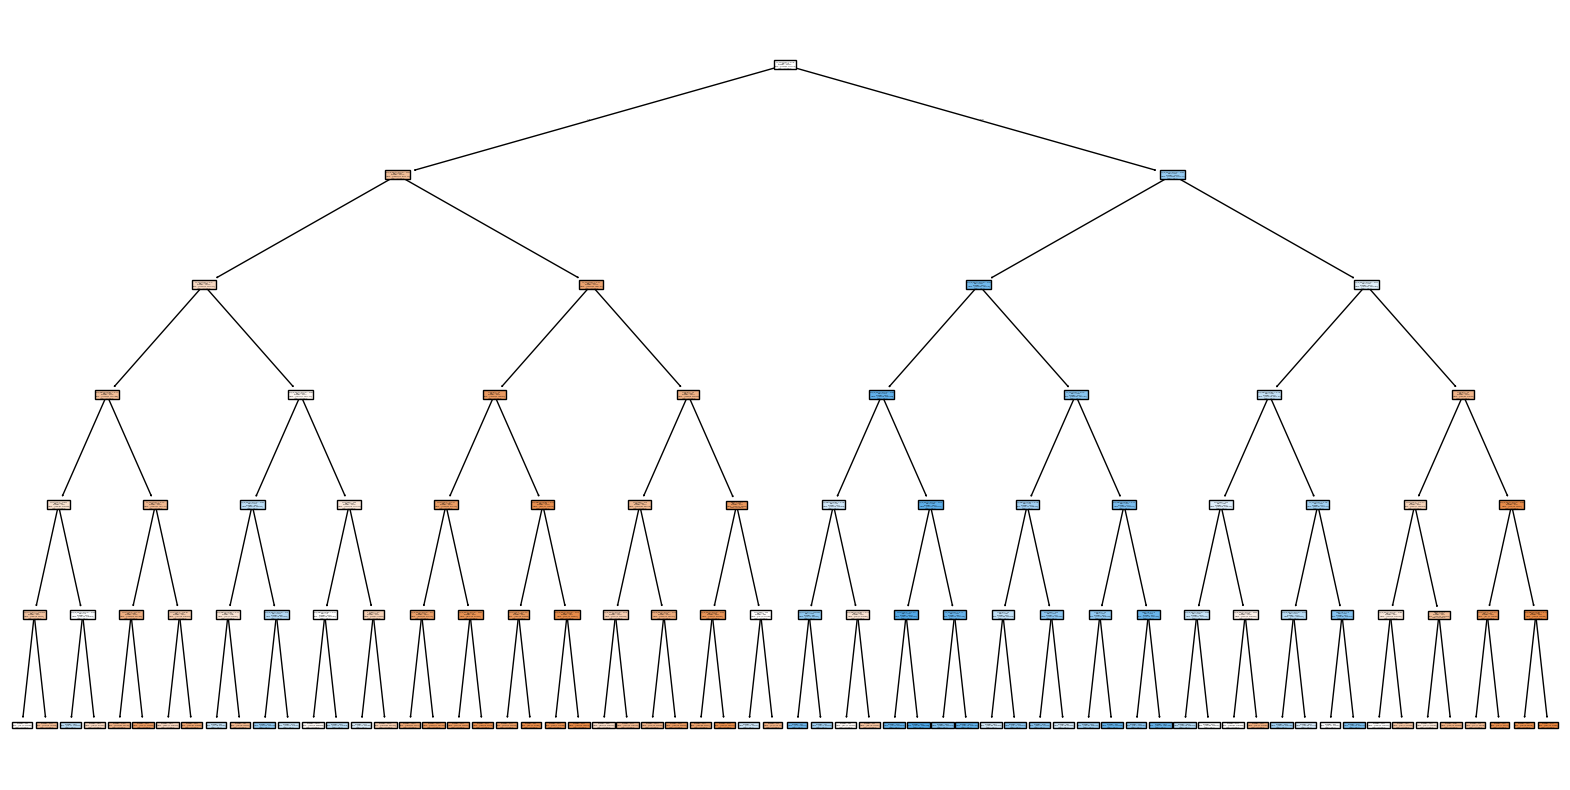

In [18]:
from sklearn.tree import plot_tree

# Get the best estimator from the RandomizedSearchCV
best_model = rscv.best_estimator_

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=train_data.columns, class_names=['Not Top 20', 'Top 20'], filled=True)
plt.show()